<a href="https://colab.research.google.com/github/ameyaoka/-makemore-/blob/main/makemore_MPL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A neural probabilistic language model



### mlp - multilayer perceptron

In [20]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot
%matplotlib inline

### Download data

In [21]:
! wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

--2023-06-17 07:58:51--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt.1’

names.txt.1         100%[===================>] 222.80K  --.-KB/s    in 0.03s   

2023-06-17 07:58:51 (6.82 MB/s) - ‘names.txt.1’ saved [228145/228145]



In [22]:
words =  open('names.txt','r').read().splitlines()

In [23]:
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [24]:
len(words) # total vocabulary

32033

1.  The set() function is used to remove duplicate characters, ensuring each character appears only once.
  - list() is then used to convert the set back into a list.'
  - sorted() is applied to sort the characters in alphabetical order.
2.  stoi : we create a maping from chars in char list to integers.
  - enumerate iterates over elements in char  and return (index , element) pair .
  - i represents position of element in chars and s represents element itself.
  - we create a dictionary of key ,val pair where char is key and mapped to index i+1 ( 0 is reserved for special char start and end )

3. itos is dictionary similar to stoi but reversed number to pair .
  - stoi.items() returns a view object that represents the key-value pairs from the stoi dictionary.


In [25]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.']=0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


## Build the dataset

1. block_size is how many chars to serve as input for prediction .
2. initialize empty list of input and output .
3. loop for iterating over words
4. print (w) prints whole word.
5. create a new list with name context . initialize thi list with block_size no of zeros (3)
6. use for loop to iterate over each character in word (w) and '.'  as end of word token.
7.  using stoi defined earlier convert word to its corresponding index. store index in var ix.
8. append the current context into X ( we use context bec we want input as 3 char .first context will always be 000 .
9. append index ix into Y .( labels )
10. print chars from index i in context which is 0 for first iteratin. then print ---> and print char with index ix which is label.
11. Now we have to update context next input should be [ ..e] ie [0,0,ix] .
12.convert list X into pytorch tensor.
13. convert list of Y into pytorch tensor.


In [26]:

block_size = 3  # how many chars serve as input for prediction of next word
X ,Y =[],[]         # Initialize empty lists for input-output pairs.

for w in words[:5]: # iterate over words (first 5)

  print(w)              # print word
  context = [0]*block_size      # initialize list with name context .
                                # This means that initially, the context list
                                # is filled with block_size number of zeros
                                # block_size =3 , context = [0,0,0]
  for ch in w + '.':        #Iterate over each character in the current word,
    ix= stoi[ch]            # convert the character to its corresponding index
    X.append(context)        # Append the current context to the input list "X
    Y.append(ix)              # append current index to output list Y
    print(''.join(itos[i] for i in context), '--->', itos[ix])# Append the current context to the input list "X
    context = context[1:] + [ix]    # Update the context by removing the first element and adding the current index

X = torch.tensor(X)  # Convert the input list "X" to a PyTorch tensor
Y = torch.tensor(Y)  # Convert the output list "Y" to a PyTorch tensor

emma
... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
olivia
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .
ava
... ---> a
..a ---> v
.av ---> a
ava ---> .
isabella
... ---> i
..i ---> s
.is ---> a
isa ---> b
sab ---> e
abe ---> l
bel ---> l
ell ---> a
lla ---> .
sophia
... ---> s
..s ---> o
.so ---> p
sop ---> h
oph ---> i
phi ---> a
hia ---> .


In [27]:
X.shape , X.dtype , Y.shape , Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

In [28]:
X # training examples

tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        [ 5, 13, 13],
        [13, 13,  1],
        [ 0,  0,  0],
        [ 0,  0, 15],
        [ 0, 15, 12],
        [15, 12,  9],
        [12,  9, 22],
        [ 9, 22,  9],
        [22,  9,  1],
        [ 0,  0,  0],
        [ 0,  0,  1],
        [ 0,  1, 22],
        [ 1, 22,  1],
        [ 0,  0,  0],
        [ 0,  0,  9],
        [ 0,  9, 19],
        [ 9, 19,  1],
        [19,  1,  2],
        [ 1,  2,  5],
        [ 2,  5, 12],
        [ 5, 12, 12],
        [12, 12,  1],
        [ 0,  0,  0],
        [ 0,  0, 19],
        [ 0, 19, 15],
        [19, 15, 16],
        [15, 16,  8],
        [16,  8,  9],
        [ 8,  9,  1]])

In [29]:
Y # labels

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

In [62]:
C = torch.randn((28,2))

In [31]:
C

tensor([[-1.5138,  0.8085],
        [ 0.0770,  0.0496],
        [-0.1658,  1.9058],
        [-0.3282,  0.2545],
        [-0.1707,  0.1356],
        [-0.1013, -0.2497],
        [ 1.2595, -1.8556],
        [-0.3885,  1.4047],
        [ 1.0528, -0.3003],
        [ 0.2143,  1.0929],
        [ 0.8773, -1.2914],
        [-0.6638,  1.3628],
        [-0.8361,  0.3593],
        [-0.7221, -0.6921],
        [ 0.3553, -0.9659],
        [ 1.1554, -0.1508],
        [-1.1474,  0.3976],
        [-0.6458,  0.5982],
        [-0.5754, -0.4031],
        [ 0.5220,  0.1816],
        [ 1.1738, -1.2002],
        [ 0.4206, -1.4527],
        [-2.0827,  0.7660],
        [ 1.3753,  0.0817],
        [ 0.8522,  0.5926],
        [ 0.0304,  2.1331],
        [ 1.7509, -0.1253]])

In [32]:
F.one_hot(torch.tensor(5),num_classes=27)

tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0])

In [33]:
# Take one hot vect and mulitply by C
# one_hot encoding by default is int . so need to convert to float.
F.one_hot(torch.tensor(5),num_classes=27).float() @ C


tensor([-0.1013, -0.2497])

In [34]:
C[5]

tensor([-0.1013, -0.2497])

- both output of above lines are same  .

- Pytorch indexing -- learn

In [35]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [63]:
emb

tensor([[[ 2.4189, -0.2593],
         [ 2.4189, -0.2593],
         [ 2.4189, -0.2593]],

        [[ 2.4189, -0.2593],
         [ 2.4189, -0.2593],
         [-0.4840,  1.0009]],

        [[ 2.4189, -0.2593],
         [-0.4840,  1.0009],
         [ 2.1073, -1.2442]],

        [[-0.4840,  1.0009],
         [ 2.1073, -1.2442],
         [ 2.1073, -1.2442]],

        [[ 2.1073, -1.2442],
         [ 2.1073, -1.2442],
         [ 0.6537, -1.7795]],

        [[ 2.4189, -0.2593],
         [ 2.4189, -0.2593],
         [ 2.4189, -0.2593]],

        [[ 2.4189, -0.2593],
         [ 2.4189, -0.2593],
         [-0.8339,  0.1757]],

        [[ 2.4189, -0.2593],
         [-0.8339,  0.1757],
         [ 0.3373,  2.1081]],

        [[-0.8339,  0.1757],
         [ 0.3373,  2.1081],
         [ 0.7642, -0.7154]],

        [[ 0.3373,  2.1081],
         [ 0.7642, -0.7154],
         [ 0.6602, -1.0067]],

        [[ 0.7642, -0.7154],
         [ 0.6602, -1.0067],
         [ 0.7642, -0.7154]],

        [[ 0.6602, -1

In [36]:
# weights
W1 = torch.randn((6,100))
# bias
b1 = torch.randn(100)

In [37]:
torch.cat([emb[:,0,:],emb[:,1,:],emb[:,2,:]],1)

tensor([[-1.5138,  0.8085, -1.5138,  0.8085, -1.5138,  0.8085],
        [-1.5138,  0.8085, -1.5138,  0.8085, -0.1013, -0.2497],
        [-1.5138,  0.8085, -0.1013, -0.2497, -0.7221, -0.6921],
        [-0.1013, -0.2497, -0.7221, -0.6921, -0.7221, -0.6921],
        [-0.7221, -0.6921, -0.7221, -0.6921,  0.0770,  0.0496],
        [-1.5138,  0.8085, -1.5138,  0.8085, -1.5138,  0.8085],
        [-1.5138,  0.8085, -1.5138,  0.8085,  1.1554, -0.1508],
        [-1.5138,  0.8085,  1.1554, -0.1508, -0.8361,  0.3593],
        [ 1.1554, -0.1508, -0.8361,  0.3593,  0.2143,  1.0929],
        [-0.8361,  0.3593,  0.2143,  1.0929, -2.0827,  0.7660],
        [ 0.2143,  1.0929, -2.0827,  0.7660,  0.2143,  1.0929],
        [-2.0827,  0.7660,  0.2143,  1.0929,  0.0770,  0.0496],
        [-1.5138,  0.8085, -1.5138,  0.8085, -1.5138,  0.8085],
        [-1.5138,  0.8085, -1.5138,  0.8085,  0.0770,  0.0496],
        [-1.5138,  0.8085,  0.0770,  0.0496, -2.0827,  0.7660],
        [ 0.0770,  0.0496, -2.0827,  0.7

- **generalization of above code**

In [38]:
torch.cat(torch.unbind(emb,1),1)

tensor([[-1.5138,  0.8085, -1.5138,  0.8085, -1.5138,  0.8085],
        [-1.5138,  0.8085, -1.5138,  0.8085, -0.1013, -0.2497],
        [-1.5138,  0.8085, -0.1013, -0.2497, -0.7221, -0.6921],
        [-0.1013, -0.2497, -0.7221, -0.6921, -0.7221, -0.6921],
        [-0.7221, -0.6921, -0.7221, -0.6921,  0.0770,  0.0496],
        [-1.5138,  0.8085, -1.5138,  0.8085, -1.5138,  0.8085],
        [-1.5138,  0.8085, -1.5138,  0.8085,  1.1554, -0.1508],
        [-1.5138,  0.8085,  1.1554, -0.1508, -0.8361,  0.3593],
        [ 1.1554, -0.1508, -0.8361,  0.3593,  0.2143,  1.0929],
        [-0.8361,  0.3593,  0.2143,  1.0929, -2.0827,  0.7660],
        [ 0.2143,  1.0929, -2.0827,  0.7660,  0.2143,  1.0929],
        [-2.0827,  0.7660,  0.2143,  1.0929,  0.0770,  0.0496],
        [-1.5138,  0.8085, -1.5138,  0.8085, -1.5138,  0.8085],
        [-1.5138,  0.8085, -1.5138,  0.8085,  0.0770,  0.0496],
        [-1.5138,  0.8085,  0.0770,  0.0496, -2.0827,  0.7660],
        [ 0.0770,  0.0496, -2.0827,  0.7

In [39]:
a = torch.arange(18)

In [40]:
a.shape

torch.Size([18])

In [41]:
a.view(3,3,2)

tensor([[[ 0,  1],
         [ 2,  3],
         [ 4,  5]],

        [[ 6,  7],
         [ 8,  9],
         [10, 11]],

        [[12, 13],
         [14, 15],
         [16, 17]]])

In [42]:
a.view(9,2)

tensor([[ 0,  1],
        [ 2,  3],
        [ 4,  5],
        [ 6,  7],
        [ 8,  9],
        [10, 11],
        [12, 13],
        [14, 15],
        [16, 17]])

- storage remains same but seen as different
-Blog below goes in depth
- http://blog.ezyang.com/2019/05/pytorch-internals/

**Imp**
- **In storage A tensor is always representated as one dim vector.**
- **when we call view some internal attributes of view of tensor changes .**


In [43]:
a.storage()

<ipython-input-43-d39b3459ecdd>:1: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  a.storage()


 0
 1
 2
 3
 4
 5
 6
 7
 8
 9
 10
 11
 12
 13
 14
 15
 16
 17
[torch.storage.TypedStorage(dtype=torch.int64, device=cpu) of size 18]

- more effecient way .

In [44]:
emb.shape

torch.Size([32, 3, 2])

In [45]:
emb.view(32,6)

tensor([[-1.5138,  0.8085, -1.5138,  0.8085, -1.5138,  0.8085],
        [-1.5138,  0.8085, -1.5138,  0.8085, -0.1013, -0.2497],
        [-1.5138,  0.8085, -0.1013, -0.2497, -0.7221, -0.6921],
        [-0.1013, -0.2497, -0.7221, -0.6921, -0.7221, -0.6921],
        [-0.7221, -0.6921, -0.7221, -0.6921,  0.0770,  0.0496],
        [-1.5138,  0.8085, -1.5138,  0.8085, -1.5138,  0.8085],
        [-1.5138,  0.8085, -1.5138,  0.8085,  1.1554, -0.1508],
        [-1.5138,  0.8085,  1.1554, -0.1508, -0.8361,  0.3593],
        [ 1.1554, -0.1508, -0.8361,  0.3593,  0.2143,  1.0929],
        [-0.8361,  0.3593,  0.2143,  1.0929, -2.0827,  0.7660],
        [ 0.2143,  1.0929, -2.0827,  0.7660,  0.2143,  1.0929],
        [-2.0827,  0.7660,  0.2143,  1.0929,  0.0770,  0.0496],
        [-1.5138,  0.8085, -1.5138,  0.8085, -1.5138,  0.8085],
        [-1.5138,  0.8085, -1.5138,  0.8085,  0.0770,  0.0496],
        [-1.5138,  0.8085,  0.0770,  0.0496, -2.0827,  0.7660],
        [ 0.0770,  0.0496, -2.0827,  0.7

In [46]:
emb.view(32,6) == torch.cat(torch.unbind(emb,1),1)

tensor([[True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, T

In [47]:
h= torch.tan(emb.view(-1,6) @ W1 + b1)

In [48]:
h

tensor([[ -1.8856,  -1.3983,  -5.6108,  ...,   2.0148,  -0.8737,  -0.5892],
        [ -2.4453, -16.3634,   0.1890,  ...,  -4.0186, -16.1605,  18.0252],
        [ -1.5594,  -0.3666,  -1.0888,  ...,   1.3293,  13.7084,   1.1888],
        ...,
        [ -1.6612,  -0.4090,  -2.0108,  ...,  -0.4999,  -3.0467,   0.9809],
        [  0.2694,  -2.8632,   0.0603,  ...,  -0.7290,   0.5677, -41.0584],
        [ -2.6885,  -0.2414,  -3.2311,  ...,  -8.9168,  -2.9517,  -1.1081]])

- inputs are 100
- outputs are 27 ( possible category)
- bias are 27

In [49]:
W2 = torch.randn((100,27))

b2 = torch.randn(27)

- logits = output
-

In [50]:
logits = h @ W2 +b2

In [51]:
logits.shape

torch.Size([32, 27])

In [52]:
counts = logits.exp()

In [53]:
# normalised
prob = counts / counts.sum(1,keepdims=True)

In [54]:
loss = -prob[torch.arange(32),Y].log().mean()

In [55]:
F.cross_entropy(logits,Y)

tensor(688.1730)

### Full neural network  neural net

- Dataset
- X - input is (32,3)(3 words )
- Y -  labels (32)(expected word)



In [56]:
X.shape , Y.shape

(torch.Size([32, 3]), torch.Size([32]))

1. g - This will ensure that the random numbers generated by the torch.randn functions are reproducible.
2. This line creates a tensor C of shape (27, 10) and fills it with random numbers from a normal distribution with mean 0 and variance 1.

3. w1,w2,b1,b2, weights and biases.

4. parameters : This line creates a list parameters containing the tensors C, W1, b1, W2, and b2. This list will be used to train the neural network.

In [57]:


g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]



In [58]:
for p in parameters:
  p.requires_grad = True


-  the sum function to calculate the total number of parameters in the list parameters

- nelement() function is used to count the number of elements in a tensor.

In [59]:
sum(p.nelement() for p in parameters) # number of parameters in total


3481

- loof itertates over 1000 times.
- emb is input data X passed  through embedding layer C .
-

- h is the hidden laeyer . we apply hyperbolic tangent activtion to matrix multiplication of input emb with w1 and bias

-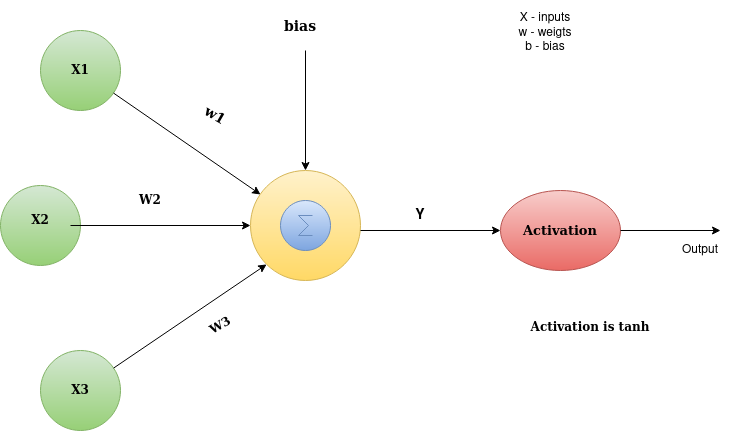


In [60]:
# fordward pass
for _ in range(1000):
  emb = C[X]
  h = torch.tanh(emb.view(-1,6) @ W1 + b1 )
  logits = h @ W2 +b2
  loss = F.cross_entropy(logits ,Y)
# backward pass
  for  p in parameters:
    p.grad = None
  loss.backward()

# update
  for p in parameters:
    p.data += -0.1 * p.grad

print(loss.item())

0.2561509907245636


In [61]:
# training split , dev/validation split , test split
# 80% ,  10% , 10%